In [2]:
from MyCocoDetection import CocoDetection
from torchvision.transforms import transforms
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import config

#### Load data

In [3]:
# Define the path to your dataset annotations and images
ann_file = 'coco2017/annotations/instances_train2017.json'
image_root = 'coco2017/train2017/'

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])

In [4]:
def custom_collate_fn(batch):
    filtered_batch = [(image, target) for image, target in batch if target]
    images, targets = zip(*filtered_batch)
    return images, targets

In [6]:
# Create an instance of your CocoDataset
train_dataset = CocoDetection(root=image_root, annFile=ann_file, transform=transform)
# Create a DataLoader with the custom collate function
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=custom_collate_fn
)

loading annotations into memory...
Done (t=9.78s)
creating index...
index created!
loading annotations into memory...
Done (t=10.69s)
creating index...
index created!


#### Model

In [8]:
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
preprocess = weights.transforms()
num_classes = 91
model = maskrcnn_resnet50_fpn_v2(
    weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
    num_classes=num_classes
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
# Modify the model for training
model.train()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

#### Show images

torch.Size([480, 640])


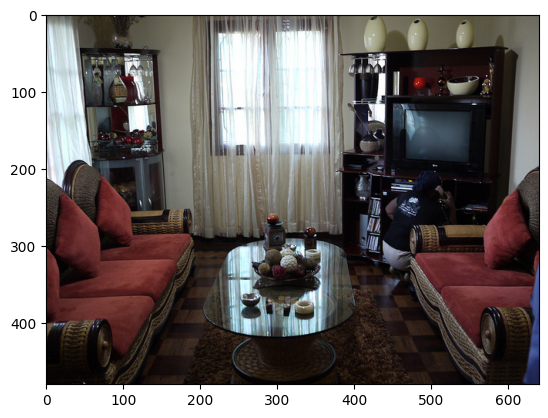

{'boxes': tensor([[  0.0000, 190.2500, 197.3400, 284.7100]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor(299273), 'labels': tensor([63])}


In [9]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataloader))
image = images[0]
imgshape = image.shape[-2:]
print(imgshape)
# Convert the image tensor to a numpy array
image = image.numpy()

# Ensure the image has the correct shape
if image.ndim == 3:
    image = image.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC

# Show the image
plt.imshow(image)
plt.show()
print(labels[0])

In [10]:
# Define the loss function and optimizer
params = [p for p in model.parameters() if p.requires_grad]
# criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.SGD(params, lr=0.08, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config.step_size, config.gamma)

#### Training

In [11]:
# Training loop
for epoch in range(config.num_epochs):
    print("Epoch:", epoch)
    running_loss = 0.0
    # Iterate over the training dataset
    for images, targets in train_dataloader:
        images = list(image.to(config.device) for image in images)
        targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        outputs = model(images, targets)
        # Compute loss
        # loss = outputs['loss_mask']
        total_loss = sum(loss for loss in outputs.values())
        # Backward pass
        total_loss.backward()
        print(f"total_loss: {total_loss}")

        # Update the model parameters
        optimizer.step()

        # Clear the gradients
        optimizer.zero_grad()
        
        # Update the running loss
        running_loss += total_loss.item()
        print(f"Running Loss: {running_loss:.4f}")

    # Adjust learning rate
    lr_scheduler.step()

    # Compute the average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)

    # Print the loss for the epoch
    print(f"Epoch [{epoch + 1}/{config.num_epochs}], Loss: {epoch_loss:.4f}")

Epoch: 0
tensor(5.2990, grad_fn=<AddBackward0>)
5.298990726470947
tensor(0.8858, grad_fn=<AddBackward0>)
6.184753596782684
tensor(1.8726, grad_fn=<AddBackward0>)
8.05731576681137
tensor(0.9986, grad_fn=<AddBackward0>)
9.055894196033478


KeyboardInterrupt: 